# Keras-Imbalanced-Data-Detecting-Fraudulent-Transactions

Welcome to a new Keras project!

In this project, we are demonstrating how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. We will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

We will use [Keras](../../guide/keras/overview.ipynb) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data.

Main steps include:
* Loading a CSV file using Pandas.
* Creating train, validation, and test sets.
* Defining and training a model using Keras (including setting class weights).
* Evaluating the model using various metrics (including precision and recall).
* Trying common techniques for dealing with imbalanced data like:
    * Class weighting 
    * Oversampling

## Table of Contents
- [1 - Set up the working directory & Import packages ](#1)
- [2 - Load the dataset using Pandas](#2)
- [3 - Preprocess the dataset](#3)
    - [3.1 - Clean the data ](#3-1)
    - [3.2 - Split the data](#3-2)
    - [3.3 - Normalize the data](#3-3)
- [4 - Baseline model](#4)
    - [4.1 - Define the model](#4-1)
    - [4.2 - Train the model](#4-2)
    - [4.3 - Evaluate the model](#4-3)
- [5 - Model with class weight](#5)
    - [5.1 - Calculate class weights](#5-1)
    - [5.2 - Train a model with class weights](#5-2)
    - [5.3 - Evaluate the model](#5-3)
- [6 - Model with Oversampling](#6)
    - [6.1 - Oversample the minority class by using tf.data](#6-1)
    - [6.2 - Train the model](#6-2)
    - [6.3 - Evaluate the model](#6-3)

<a name='1'></a>
## 1 - Set up the working directory & Import packages ##

In [1]:
# Move to the working directory on Google Drive as using Google Colab
import os

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  PROJECT_ROOT ="/content/drive/MyDrive/GitHub/Keras-Imbalanced-Data-Detecting-Fraudulent-Transactions"
  os.chdir(PROJECT_ROOT)
  !pwd
else:
  PROJECT_ROOT ="."

Running on CoLab
/content/drive/MyDrive/GitHub/Keras-Imbalanced-Data-Detecting-Fraudulent-Transactions


In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('talk')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
params = {'legend.fontsize': 12,
          'figure.figsize': (10, 5),
          'axes.labelsize': 12,
          'axes.titlesize':12,
          'xtick.labelsize':12,
          'ytick.labelsize':12}
plt.rcParams.update(params)

<a name='2'></a>
## 2 - Load the dataset using Pandas ##

The [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset contains transactions made by credit cards in September 2013 by European cardholders.

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. 
- Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
- Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
- Feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. 
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Since this is a relatively small structed data, we will use Pandas to download it from a URL, and load it into a Pandas dataframe.

In [4]:
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
csv_file = 'datasets/creditcard.csv'
tf.keras.utils.get_file('creditcard.csv',dataset_url,cache_dir=PROJECT_ROOT)
raw_df = pd.read_csv(csv_file)
raw_df.head()

150839296/150828752 [==============================] - 2s 0us/step


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Let's look at the dataset imbalance:

In [5]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



<a name='3'></a>
## 3 - Preprocess the dataset ##

<a name='3-1'></a>
### 3.1 - Clean the data
The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its huge range.

In [6]:
# Make a copy
cleaned_df = raw_df.copy()

# Drop the `Time` column.
cleaned_df.pop('Time')

# Convert the `Amount` column to log-space.
eps = 0.001 
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)
cleaned_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log Ammount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


<a name='3-2'></a>
### 3.2 - Split the data
Split the dataset into train, validation, and test sets. 
* The train set is used to train the model.
* The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. 
* The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where overfitting is a significant concern from the lack of training data.

In [7]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


In [8]:
neg, pos = np.bincount(train_labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 182276
    Positive: 301 (0.17% of total)



In [9]:
neg, pos = np.bincount(val_labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 45569
    Positive: 82 (0.18% of total)



<a name='3-3'></a>
### 3.3 - Normalize the data
Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

In [10]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

### Explore the data distributions
Next compare the distributions of the positive and negative examples over a few features.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


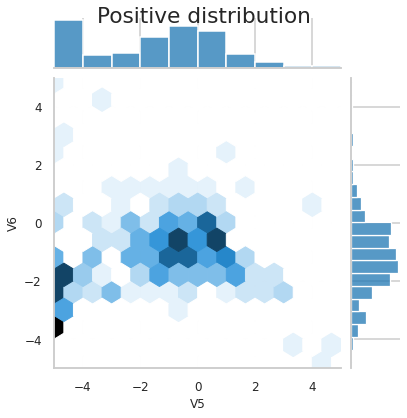

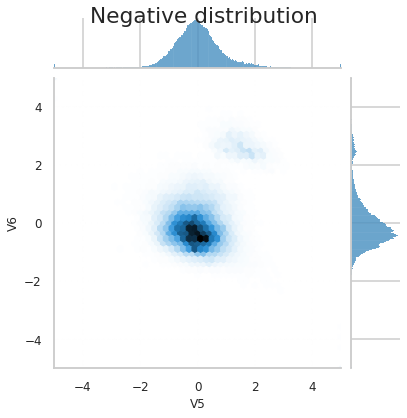

In [11]:
bool_train_labels = train_labels != 0
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Negative distribution")
plt.show()

As we can see, after normalized, the input are mostly concentrated in the +/- 2 range. And the positive examples contain a much higher rate of extreme values than the negative examples does.

<a name='4'></a>
## 4 - Baseline model ##

**Note**: this model will not handle the class imbalance well. You will improve it later in this tutorial.

<a name='4-1'></a>
### 4.1 - Define the model


Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.

In [13]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


Define a function that creates a simple neural network with a densly connected hidden layer, a dropout layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent.


In [14]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(16, activation='relu',input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Initialize the bias
It has been learned that the correct initial bias will speed up convergence and eliminate “hockey stick” loss curves where in the first few iteration your network is basically just learning the bias.

In [15]:
neg, pos = np.bincount(train_labels)
initial_bias = np.log([pos/neg])
model = make_model(output_bias=initial_bias)
print(model.summary())
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________
None
Loss: 0.0117


### Create a checkpoint of the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training:

In [16]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

<a name='4-2'></a>
### 4.2 - Train the model


In [17]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 4s 15ms/step - loss: 0.0115 - tp: 87.0000 - fp: 149.0000 - tn: 363801.0000 - fn: 515.0000 - accuracy: 0.9982 - precision: 0.3686 - recall: 0.1445 - auc: 0.7710 - prc: 0.1333 - val_loss: 0.0065 - val_tp: 29.0000 - val_fp: 7.0000 - val_tn: 45480.0000 - val_fn: 53.0000 - val_accuracy: 0.9987 - val_precision: 0.8056 - val_recall: 0.3537 - val_auc: 0.8713 - val_prc: 0.5505
Epoch 2/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0070 - tp: 138.0000 - fp: 38.0000 - tn: 181937.0000 - fn: 163.0000 - accuracy: 0.9989 - precision: 0.7841 - recall: 0.4585 - auc: 0.8783 - prc: 0.5289 - val_loss: 0.0056 - val_tp: 50.0000 - val_fp: 8.0000 - val_tn: 45479.0000 - val_fn: 32.0000 - val_accuracy: 0.9991 - val_precision: 0.8621 - val_recall: 0.6098 - val_auc: 0.8779 - val_prc: 0.5965
Epoch 3/100
90/90 [==============================] - 0s 5ms/step - loss: 0.0063 - tp: 153.0000 - fp: 26.0000 - tn: 181949.0000 - fn: 148.0000 - accuracy:

### Check training history

Let's produce some plots of the model's loss and other metrics on the training and validation set. These are useful to check for overfitting, which we can learn more about in the [Overfit and underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) tutorial.


In [18]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

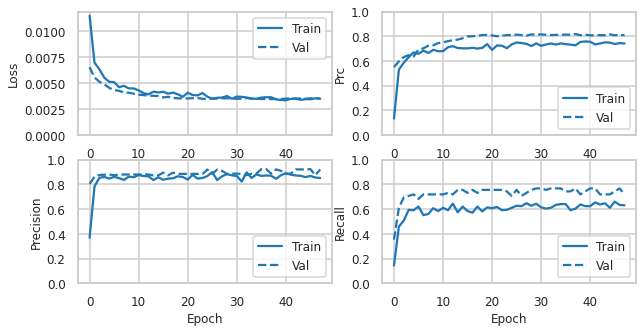

In [19]:
plot_metrics(baseline_history)

**Note**: The validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

<a name='4-3'></a>
### 4.3 - Evaluate the model

### Evaluate metrics

We use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label:

In [20]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [21]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.002877643797546625
tp :  89.0
fp :  12.0
tn :  56841.0
fn :  20.0
accuracy :  0.9994382262229919
precision :  0.8811880946159363
recall :  0.8165137767791748
auc :  0.9584225416183472
prc :  0.8622764348983765

Legitimate Transactions Detected (True Negatives):  56841
Legitimate Transactions Incorrectly Detected (False Positives):  12
Fraudulent Transactions Missed (False Negatives):  20
Fraudulent Transactions Detected (True Positives):  89
Total Fraudulent Transactions:  109


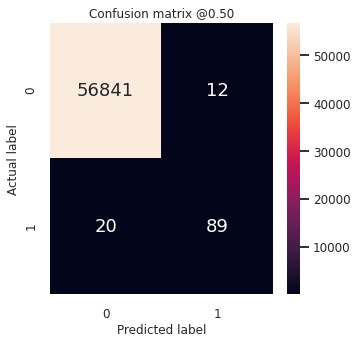

In [22]:
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, we would likely want to have even fewer false negatives (Fraudulent Transactions Missed) despite the cost of increasing the number of false positives (Legitimate Transactions Incorrectly Detected ). This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [23]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

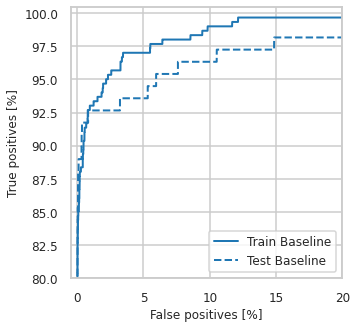

In [24]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')
plt.show()

### Plot the AUPRC

Now plot the [AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC). Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.

In [25]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

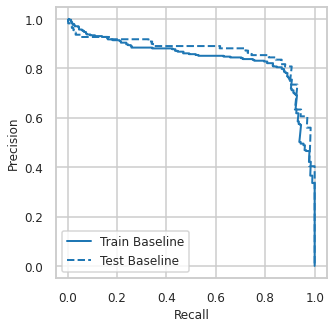

In [26]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower left')
plt.show()

- It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as we might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. 
- It is important to consider the costs of different types of errors in the context of the problem. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

<a name='5'></a>
## 5 - Model with class weight

The goal is to identify fraudulent transactions, but we don't have very many of those positive samples to work with, so we want to have the classifier heavily weight the few examples that are available. We can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

<a name='5-1'></a>
### 5.1 - Calculate class weights



In [27]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.13
Weight for class 1: 75.70


<a name='5-2'></a>
### 5.2 - Train a model with class weights

**Note**: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `tf.keras.optimizers.SGD`, may fail. The optimizer used here, `tf.keras.optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [28]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
90/90 [==============================] - 3s 17ms/step - loss: 0.4273 - tp: 195.0000 - fp: 671.0000 - tn: 238157.0000 - fn: 215.0000 - accuracy: 0.9963 - precision: 0.2252 - recall: 0.4756 - auc: 0.8424 - prc: 0.2750 - val_loss: 0.0107 - val_tp: 56.0000 - val_fp: 32.0000 - val_tn: 45455.0000 - val_fn: 26.0000 - val_accuracy: 0.9987 - val_precision: 0.6364 - val_recall: 0.6829 - val_auc: 0.9139 - val_prc: 0.5669
Epoch 2/100
90/90 [==============================] - 0s 5ms/step - loss: 0.2159 - tp: 187.0000 - fp: 1208.0000 - tn: 180767.0000 - fn: 114.0000 - accuracy: 0.9927 - precision: 0.1341 - recall: 0.6213 - auc: 0.8856 - prc: 0.2744 - val_loss: 0.0148 - val_tp: 64.0000 - val_fp: 69.0000 - val_tn: 45418.0000 - val_fn: 18.0000 - val_accuracy: 0.9981 - val_precision: 0.4812 - val_recall: 0.7805 - val_auc: 0.9270 - val_prc: 0.6680
Epoch 3/100
90/90 [==============================] - 0s 5ms/step - loss: 0.1399 - tp: 217.0000 - fp: 1871.0000 - tn: 180104.0000 - fn: 84.0000 - acc

### Check training history

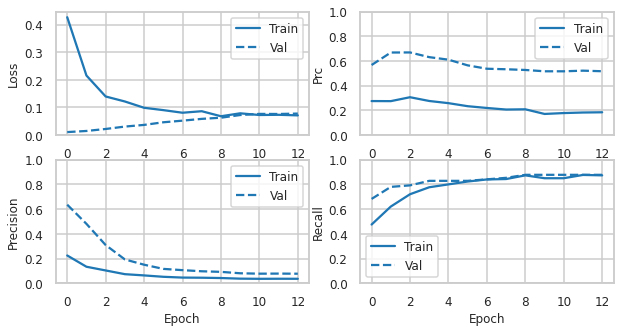

In [29]:
plot_metrics(weighted_history)

<a name='5-3'></a>
### 5.3 - Evaluate the model

### Evaluate metrics

In [30]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.02181929722428322
tp :  90.0
fp :  179.0
tn :  56674.0
fn :  19.0
accuracy :  0.9965239763259888
precision :  0.3345724940299988
recall :  0.8256880640983582
auc :  0.9614455699920654
prc :  0.7069999575614929

Legitimate Transactions Detected (True Negatives):  56674
Legitimate Transactions Incorrectly Detected (False Positives):  179
Fraudulent Transactions Missed (False Negatives):  19
Fraudulent Transactions Detected (True Positives):  90
Total Fraudulent Transactions:  109


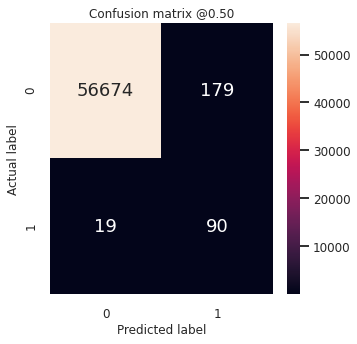

In [31]:
weighted_results = weighted_model.evaluate(test_features, test_labels,batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here we can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (we wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). The trade-offs between these different types of errors should be considered carefully.

### Plot the ROC

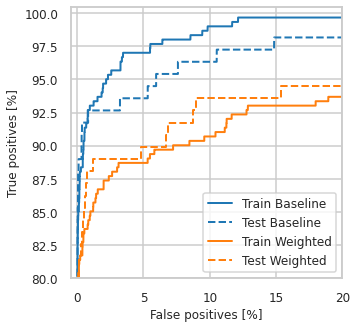

In [32]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
plt.legend(loc='lower right')
plt.show()

### Plot the AUPRC

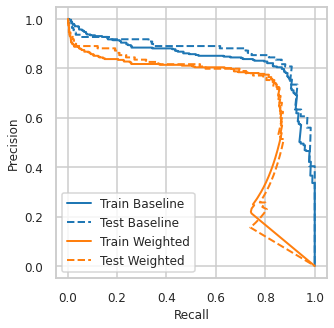

In [33]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
plt.legend(loc='lower left')
plt.show()

<a name='6'></a>
## 6 - Model with Oversampling
Oversampling the minority class is one of the resampling techniques that can help the dataset balanced. This can be a good option when the data is limited

<a name='6-1'></a>
### 6.1 - Oversample the minority class by using `tf.data`

#### Create balanced examples with a positive dataset and a negative dataset

In [34]:
def make_ds(features, labels, buffer_size = 100000):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(buffer_size).repeat()
  return ds

In [35]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]
pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

#### Merge the two dataset together using `experimental.sample_from_datasets`:

In [36]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

Instructions for updating:
Use `tf.data.Dataset.random(...)`.


<a name='6-2'></a>
### 6.2 - Train the model

**Note**: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and a large number of epochs should be assigned for the training process.

In [38]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 4s 114ms/step - loss: 0.9272 - tp: 14392.0000 - fp: 10813.0000 - tn: 66614.0000 - fn: 6103.0000 - accuracy: 0.8273 - precision: 0.5710 - recall: 0.7022 - auc: 0.8880 - prc: 0.7637 - val_loss: 0.8029 - val_tp: 70.0000 - val_fp: 23640.0000 - val_tn: 21847.0000 - val_fn: 12.0000 - val_accuracy: 0.4810 - val_precision: 0.0030 - val_recall: 0.8537 - val_auc: 0.8449 - val_prc: 0.3632
Epoch 2/1000
20/20 [==============================] - 1s 60ms/step - loss: 0.6680 - tp: 16304.0000 - fp: 9760.0000 - tn: 10848.0000 - fn: 4048.0000 - accuracy: 0.6629 - precision: 0.6255 - recall: 0.8011 - auc: 0.7978 - prc: 0.8624 - val_loss: 0.7065 - val_tp: 71.0000 - val_fp: 18862.0000 - val_tn: 26625.0000 - val_fn: 11.0000 - val_accuracy: 0.5858 - val_precision: 0.0038 - val_recall: 0.8659 - val_auc: 0.8793 - val_prc: 0.5261
Epoch 3/1000
20/20 [==============================] - 1s 65ms/step - loss: 0.5447 - tp: 17496.0000 - fp: 8083.0000 - tn: 12177.0000 

### Check training history

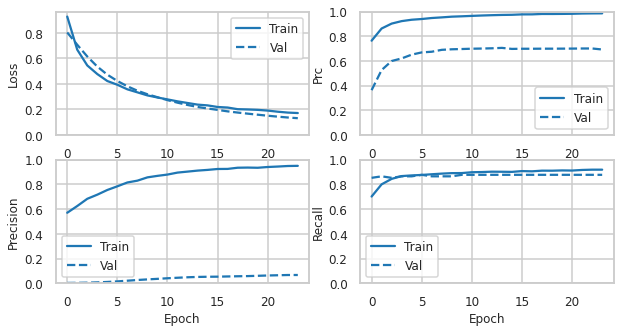

In [39]:
plot_metrics(resampled_history)

<a name='6-3'></a>
### 6.3 - Evaluate the model

### Evaluate metrics

In [40]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.2210184633731842
tp :  101.0
fp :  1746.0
tn :  55107.0
fn :  8.0
accuracy :  0.9692075252532959
precision :  0.054683271795511246
recall :  0.9266055226325989
auc :  0.9777476191520691
prc :  0.7646790146827698

Legitimate Transactions Detected (True Negatives):  55107
Legitimate Transactions Incorrectly Detected (False Positives):  1746
Fraudulent Transactions Missed (False Negatives):  8
Fraudulent Transactions Detected (True Positives):  101
Total Fraudulent Transactions:  109


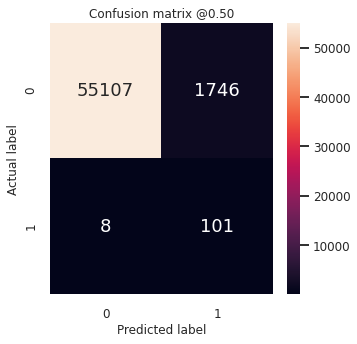

In [41]:
resampled_results = resampled_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

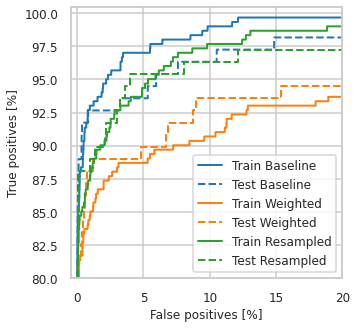

In [42]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')
plt.show()

### Plot the AUPRC

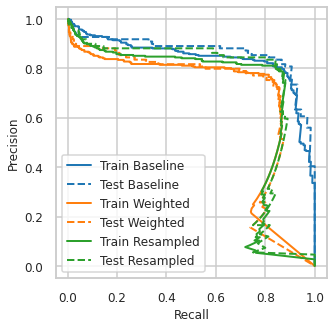

In [43]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower left')
plt.show()

## Final thoughts:

- Imbalanced data classification is an inherently difficult task since there are so few samples to learn from. 
- We should always start with the data first and try to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of the minority class. 
- At some point, the model may struggle to improve and yield the results we want, so it is important to keep in mind the context of the problem and the trade offs between different types of errors.